# UJIIndoorLoc

In [228]:

import os


requirements_path = os.path.join(os.getcwd(), 'requirements.txt')

os.system(f'pip install -r {requirements_path}')
print("All dependencies have been installed.")

All dependencies have been installed.


In [208]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#feature encoding
from sklearn.preprocessing import StandardScaler


# 1. Read Data into Dataframe

In [209]:
datafolder = "../../datasets/UJIIndoorLoc"

trainfile = os.path.join(datafolder, "trainingData.csv")
validfile = os.path.join(datafolder, "validationData.csv")

#read data into pandas dataframes
train_data = pd.read_csv(trainfile)
test_data = pd.read_csv(validfile)
print("Training data shape:", train_data.shape)
test_data.head()




Training data shape: (19937, 529)


,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,WAP520,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP
0,100,100,100,100,100,100,100,100,100,100,...,100,-7515.916799,4.864890e+06,1,1,0,0,0,0,1380872703
1,100,100,100,100,100,100,100,100,100,100,...,100,-7383.867221,4.864840e+06,4,2,0,0,0,13,1381155054
2,100,100,100,100,100,100,100,100,100,100,...,100,-7374.302080,4.864847e+06,4,2,0,0,0,13,1381155095
3,100,100,100,100,100,100,100,100,100,100,...,100,-7365.824883,4.864843e+06,4,2,0,0,0,13,1381155138
4,100,100,100,100,100,100,100,100,100,100,...,100,-7641.499303,4.864922e+06,2,0,0,0,0,2,1380877774


In [210]:
# Response variables in our problem are Building, Floor, Latitude, Longitude and Relative Position
train_data[['FLOOR','BUILDINGID', 'SPACEID','RELATIVEPOSITION','USERID','PHONEID']].astype(str).describe(include=['object'])
test_data[['FLOOR','BUILDINGID', 'SPACEID','RELATIVEPOSITION','USERID','PHONEID']].astype(str).describe(include=['object'])

## X and Y-data split
# Features are the WAP columns
X_train = train_data.iloc[:,:520]
X_test = test_data.iloc[:,:520]

# Select FLOOR and BUILDINGID for location prediction
y_train = train_data[['FLOOR', 'BUILDINGID']].copy()
y_test  = test_data[['FLOOR', 'BUILDINGID']].copy()

print(y_test.head())

#histogram of space ids for test set
# Combine BUILDINGID and FLOOR into a simpler location code
# Format: "B{BUILDING}F{FLOOR}" for better readability
y_train['LOC_CODE'] = (y_train['BUILDINGID'].astype(str) + 
                       y_train['FLOOR'].astype(str)
                       )
y_test['LOC_CODE'] = (y_test['BUILDINGID'].astype(str) + 
                      y_test['FLOOR'].astype(str) 
                      )

# Keep only the combined column
y_train = y_train[['LOC_CODE']].astype('category')
y_test  = y_test[['LOC_CODE']].astype('category')

y_test.head()


   FLOOR  BUILDINGID
0      1           1
1      4           2
2      4           2
3      4           2
4      2           0


,LOC_CODE
0,11
1,24
2,24
3,24
4,02


# 2. Exploratory Data Analysis

In [211]:
# Replace the 100 values with NaN for further processing
# Transform Train data
X_train = (X_train
             .replace(to_replace=100,value=np.nan))

# Perform the same transform on Test data
X_test = (X_test
             .replace(to_replace=100,value=np.nan))

### drop NaN and show distribution

count    358763.000000
mean        -78.497211
std          12.615758
min        -104.000000
25%         -88.000000
50%         -82.000000
75%         -72.000000
max           0.000000
dtype: float64

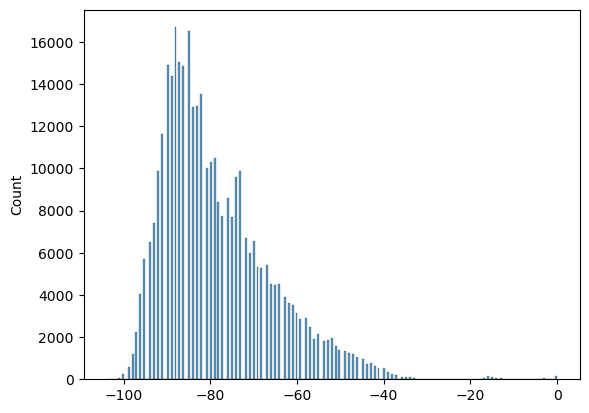

In [212]:
X_stack = X_train.stack(future_stack=True)
sns.histplot(X_stack.dropna(),kde = False)
X_stack.describe()

In [213]:
# Proportion of out of range values
sum(X_stack.isnull() == 0)/len(X_stack)

0.03460544947353394

Text(0.5, 0, 'Number of APs in range')

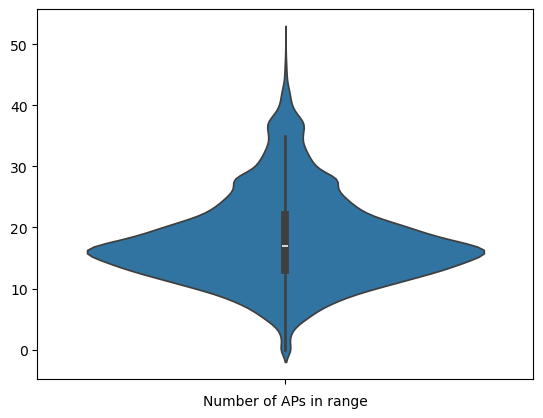

In [214]:
waps_in_range = (X_train
                 .notnull()
                 .sum(axis = 1))

fig, ax = plt.subplots(1,1)

sns.violinplot(waps_in_range, ax = ax)
ax.set_xlabel("Number of APs in range")

In [215]:
waps_in_range.describe()

count    19937.000000
mean        17.994834
std          7.333575
min          0.000000
25%         13.000000
50%         17.000000
75%         22.000000
max         51.000000
dtype: float64

In [216]:
print("Before sample removal:", len(X_train))

# Remove rows where all values are NaN
valid_rows = X_train.notnull().any(axis=1)

y_train = y_train.loc[valid_rows, :]
X_train = X_train.loc[valid_rows, :]

valid_rows_test = X_test.notnull().any(axis=1)
X_test = X_test.loc[valid_rows_test, :]
y_test = y_test.loc[valid_rows_test, :]

print("After sample removal X:", len(X_train))
print("After sample removal y:", len(y_train))


Before sample removal: 19937
After sample removal X: 19861
After sample removal y: 19861


In [217]:
# Removing columns with all NaN values
all_nan = (X_train
           .isnull()
           .all(axis=0) == False)
filtered_cols = (all_nan[all_nan]
                 .index
                 .values)

print("Before removing predictors with no in-range values", X_train.shape)

X_train = X_train.loc[:,filtered_cols]
X_test = X_test.loc[:,filtered_cols]

print("After removing predictors with no in-range values", X_train.shape)

Before removing predictors with no in-range values (19861, 520)
After removing predictors with no in-range values (19861, 465)


In [218]:
X_raw_train = X_train
X_raw_test = X_test


X_raw_train.shape, X_raw_test.shape

((19861, 465), (1111, 465))

In [ ]:
# Replace the NaN values with -110 for further processing
# Transform Train data
X_train_noNAN = (X_train
             .replace(to_replace=np.nan,value=-110))

# Perform the same transform on Test data
X_test_noNAN = (X_test
             .replace(to_replace=np.nan,value=-110))



       WAP001  WAP002  WAP005  WAP006  WAP007  WAP008  WAP009  WAP010  WAP011  \
0      -110.0  -110.0  -110.0  -110.0  -110.0  -110.0  -110.0  -110.0  -110.0   
1      -110.0  -110.0  -110.0  -110.0  -110.0  -110.0  -110.0  -110.0  -110.0   
2      -110.0  -110.0  -110.0  -110.0  -110.0   -97.0  -110.0  -110.0  -110.0   
3      -110.0  -110.0  -110.0  -110.0  -110.0  -110.0  -110.0  -110.0  -110.0   
5      -110.0  -110.0  -110.0  -110.0  -110.0  -110.0  -110.0  -110.0  -110.0   
...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
19932  -110.0  -110.0  -110.0  -110.0  -110.0  -110.0  -110.0  -110.0  -110.0   
19933  -110.0  -110.0  -110.0  -110.0  -110.0  -110.0  -110.0  -110.0  -110.0   
19934  -110.0  -110.0  -110.0  -110.0  -110.0  -110.0  -110.0  -110.0  -110.0   
19935  -110.0  -110.0  -110.0  -110.0  -110.0  -110.0  -110.0  -110.0  -110.0   
19936  -110.0  -110.0  -110.0  -110.0  -110.0  -110.0  -110.0  -110.0  -110.0   

       WAP012  ...  WAP510 

## Using Standard Scalar

<Axes: ylabel='Count'>

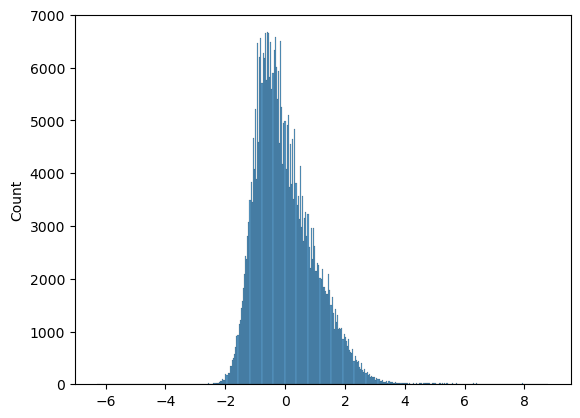

In [220]:

sc = StandardScaler()
X_std_train = sc.fit_transform(X_raw_train)
X_std_test = sc.transform(X_raw_test)

X_std_train = pd.DataFrame(X_std_train)
X_std_test = pd.DataFrame(X_std_test)

##plotting standardized data distribution
X_stack_std = X_std_train.stack(future_stack=True)
sns.histplot(X_stack_std.dropna(),kde = False)


## Random Forest can work with NaNs

In [221]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Convert categorical LOC_CODE to numeric codes
y_train_codes = y_train['LOC_CODE'].cat.codes
y_test_codes = y_test['LOC_CODE'].cat.codes

print(f"Number of unique locations: {y_train['LOC_CODE'].nunique()}")
print(f"Training samples: {len(y_train_codes)}, Test samples: {len(y_test_codes)}")

# Train classifier
clf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
clf.fit(X_std_train, y_train_codes)

# Predict on test set
y_pred = clf.predict(X_std_test)

# Evaluate
accuracy = accuracy_score(y_test_codes, y_pred)
print(f"\nAccuracy: {accuracy:.4f}")

# Show some example predictions
comparison = pd.DataFrame({
    'True': y_test['LOC_CODE'].values[:10],
    'Predicted': y_train['LOC_CODE'].cat.categories[y_pred[:10]]
})
print("\nFirst 10 predictions:")
print(comparison)








Number of unique locations: 13
Training samples: 19861, Test samples: 1111

Accuracy: 0.9064

First 10 predictions:
  True Predicted
0   11        13
1   24        23
2   24        24
3   24        24
4   02        02
5   22        22
6   23        23
7   23        23
8   22        22
9   20        20


## Standard Scalar for other classifier

<Axes: ylabel='Count'>

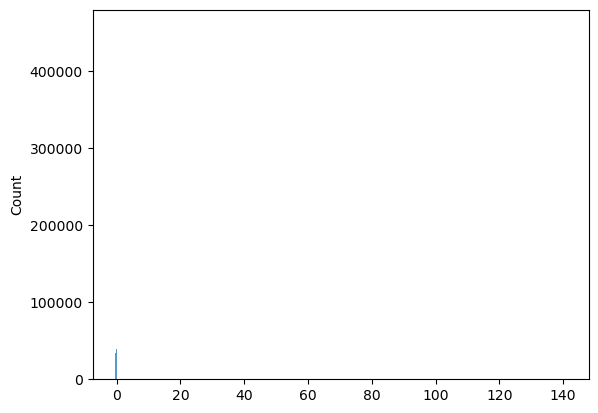

In [222]:
sc = StandardScaler()
X_std_train_noNAN = sc.fit_transform(X_train_noNAN)
X_std_test_noNAN = sc.transform(X_test_noNAN)

X_std_train_noNAN = pd.DataFrame(X_std_train_noNAN)
X_std_test_noNAN = pd.DataFrame(X_std_test_noNAN)

#plot standardized data distribution
X_stack_std_noNAN = X_std_train_noNAN.stack(future_stack=True)
sns.histplot(X_stack_std_noNAN,kde = False)

## KNN-Classifier

In [225]:
# Knn-Classifier impliementation

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report


# Convert categorical LOC_CODE to numeric codes
y_train_codes = y_train['LOC_CODE'].cat.codes
y_test_codes = y_test['LOC_CODE'].cat.codes
print(f"Number of unique locations: {y_train['LOC_CODE'].nunique()}")
print(f"Training samples: {len(y_train_codes)}, Test samples: {len(y_test_codes)}")
# Train KNN classifier
knn_clf = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
knn_clf.fit(X_std_train_noNAN, y_train_codes)
# Predict on test set
y_pred_knn = knn_clf.predict(X_std_test_noNAN)
# Evaluate
accuracy_knn = accuracy_score(y_test_codes, y_pred_knn)
print(f"\nKNN Classifier Accuracy: {accuracy_knn:.4f}")
# Show some example predictions

comparison_knn = pd.DataFrame({
    'True': y_test['LOC_CODE'].values[:10],
    'Predicted': y_train['LOC_CODE'].cat.categories[y_pred_knn[:10]]
})  

Number of unique locations: 13
Training samples: 19861, Test samples: 1111

KNN Classifier Accuracy: 0.7903


In [226]:
# Gradient Boosting Classifier implementation
from sklearn.ensemble import GradientBoostingClassifier

gb_clf = GradientBoostingClassifier(n_estimators=200, random_state=42)
gb_clf.fit(X_std_train_noNAN, y_train_codes)

y_pred_gb = gb_clf.predict(X_std_test_noNAN)
# Evaluate
accuracy_gb = accuracy_score(y_test_codes, y_pred_gb)
print(f"\nGradient Boosting Classifier Accuracy: {accuracy_gb:.4f}")


Gradient Boosting Classifier Accuracy: 0.9055


In [ ]:
# XGBoost Classifier implementation
import xgboost as xgb


xgb_clf = xgb.XGBClassifier(n_estimators=200, use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_clf.fit(X_std_train_noNAN, y_train_codes)

y_pred_xgb = xgb_clf.predict(X_std_test_noNAN)
# Evaluate
accuracy_xgb = accuracy_score(y_test_codes, y_pred_xgb)
print(f"\nXGBoost Classifier Accuracy: {accuracy_xgb:.4f}")

c:\Users\JakobOlsacher\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [22:05:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
